In [75]:
from datasets.arrow_dataset import Dataset
import torchvision.transforms as T
from datasets import load_dataset
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode
from configs import DATA_FOLDER, TRAIN_SET_FOLDER

In [76]:
img_dataset: Dataset = load_dataset("imagefolder", data_dir=DATA_FOLDER, split="train")

Resolving data files:   0%|          | 0/94 [00:00<?, ?it/s]

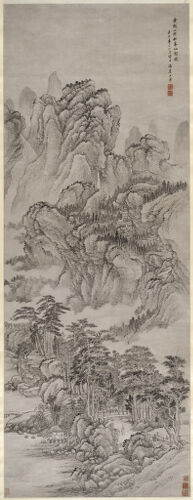

In [77]:
img_dataset[0].get("image")

In [78]:
def resize_and_pad_then_resize(img, final_size=(512, 512), padding_mode='constant', fill=0):
    """
    Resize an image to make its longest side equal to the original image's longest side,
    pad the shorter side to make the image a square, then resize to final_size.

    Args:
        img (PIL.Image): The image to resize and pad.
        final_size (tuple): The desired output size (height, width).
        padding_mode (str): Type of padding. Options include 'constant', 'edge', etc.
        fill (int, tuple): Pixel fill value for constant padding. Can be int or tuple.

    Returns:
        PIL.Image: The resized and padded, then resized image.
    """
    original_width, original_height = img.size
    max_side = max(original_width, original_height)

    # Determine new size keeping aspect ratio
    if original_width > original_height:
        scale = max_side / original_width
        new_width = max_side
        new_height = int(original_height * scale)
    else:
        scale = max_side / original_height
        new_height = max_side
        new_width = int(original_width * scale)

    # Resize the image to max_side to keep aspect ratio
    img = F.resize(img, (new_height, new_width), interpolation=InterpolationMode.LANCZOS)

    # Calculate padding amounts
    pad_width = (max_side - new_width) // 2
    pad_height = (max_side - new_height) // 2

    # Apply padding to make it a square
    img = F.pad(img, [pad_width, pad_height, pad_width, pad_height], padding_mode=padding_mode, fill=fill)

    # Final resize to the desired output size
    img = F.resize(img, final_size, interpolation=InterpolationMode.LANCZOS)
    return img

# Setup the transformation pipeline with the updated function
transform_pipeline = T.Compose([
    T.Lambda(lambda img: resize_and_pad_then_resize(img, final_size=(512, 512), padding_mode='constant', fill=0)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

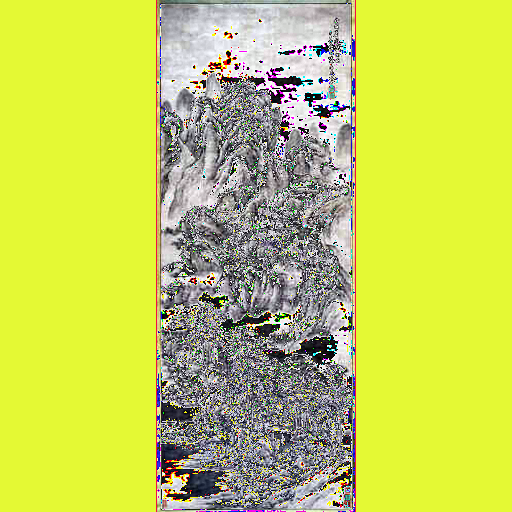

In [79]:
new_img = transform_pipeline(img_dataset[0]["image"])
tensor = new_img.squeeze(0)
unloader = T.ToPILImage()
image = unloader(tensor)
image

In [80]:
new_img.shape

torch.Size([3, 512, 512])

In [81]:
from transformers import CLIPTokenizer
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

In [82]:
def preprocess_train(examples):
    # examples are a batch of 4 images
    # we apply the transformation (reference above for what it transfomed to)
    # then apply the tokenization
    examples["pixel_values"] = [transform_pipeline(image) for image in examples["image"]]
    inputs = tokenizer([example for example in examples["caption"]],
                       padding="max_length",
                       truncation=True,
                       return_tensors="pt")

    examples["input_ids"] = inputs.input_ids
    return examples

train_set = img_dataset.map(preprocess_train, remove_columns=["image","caption"], batched=True)
train_set

Dataset({
    features: ['pixel_values', 'input_ids'],
    num_rows: 93
})

In [83]:
train_set[0].get("input_ids")

[49406,
 4271,
 3086,
 281,
 5727,
 953,
 11900,
 37450,
 568,
 257,
 24717,
 2889,
 654,
 530,
 518,
 7374,
 5603,
 5873,
 257,
 5976,
 530,
 34339,
 14593,
 267,
 272,
 277,
 275,
 275,
 268,
 272,
 280,
 272,
 272,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407,
 49407]

In [84]:
# Save as parquet
import pyarrow.parquet as pq
import os
if not os.path.exists(TRAIN_SET_FOLDER):
    os.makedirs(TRAIN_SET_FOLDER)
pq.write_table(train_set.data.table, TRAIN_SET_FOLDER + 'train_set.parquet')

<class 'list'>
torch.Size([3, 512, 512])


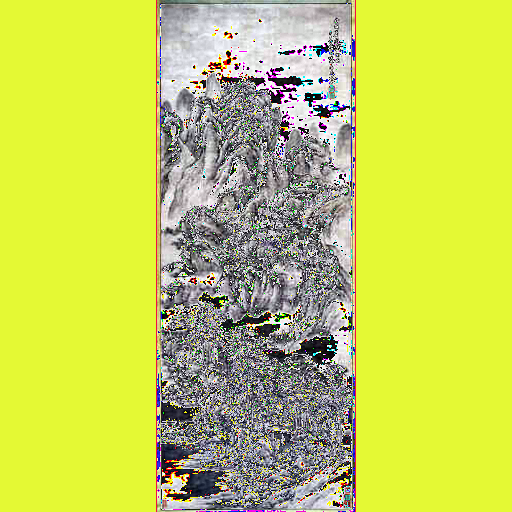

In [85]:
# Read parquet
train_set_read_from_parquet = Dataset(pq.read_table(TRAIN_SET_FOLDER + 'train_set.parquet'))
train_set_read_from_parquet[0].get('input_ids')
import torch
print(type(train_set_read_from_parquet[0]['pixel_values'])) 
new_img = train_set_read_from_parquet[0].get('pixel_values')
img_tensor = torch.tensor(new_img)
print(img_tensor.shape)
tensor = img_tensor.squeeze(0)
unloader = T.ToPILImage()
image = unloader(tensor)
image